In [19]:
from typing import List, Union, Dict
import pathlib as pl
import json
import os
import re
from datetime import datetime

import openai
import numpy as np
import pandas as pd
from sklearn import metrics as skm

from ai4chem.data import Deep4ChemDataset, ChemFluorDataset, split_on_unique_smiles, _canonicalize_smiles

with open('/Users/azadoks/.zshrc.d/10_openai_bot.sh', 'r') as f:
    api_key = f.read().split('=')[1].strip()

client = openai.OpenAI(api_key=api_key)

In [5]:
def load_jsonl(filename: os.PathLike) -> List[dict]:
    data = []
    with open(filename, 'r') as f:
        for line in f.readlines():
            data.append(json.loads(line.strip()))
    return data

def generate(job_id: str, prompts, temperature: float=0.5, max_tokens: int=256) -> List:
    response = client.fine_tuning.jobs.retrieve(job_id)
    fine_tuned_model_id = response.fine_tuned_model

    responses = client.completions.create(
        model=fine_tuned_model_id,
        prompt=prompts,
        temperature=temperature,
        max_tokens=max_tokens
    )

    return responses.to_dict()

def get_molecule_solvent(text: str) -> Dict:
    molecule = re.search(r'Molecule smiles: (.+?)\$\$\$', text).group(1)
    solvent = re.search(r'Solvent smiles: (.+?)\$\$\$', text).group(1)
    return {'molecule': _canonicalize_smiles(molecule), 'solvent': _canonicalize_smiles(solvent)}

In [6]:
chemfluor_path = '../data/chemfluor/data.csv'
deep4chem_path = '../data/deep4chem/data.csv'

chemfluor = ChemFluorDataset(chemfluor_path, canonicalize_smiles=True)
deep4chem = Deep4ChemDataset(deep4chem_path, canonicalize_smiles=True)

combined_df = pd.concat([chemfluor.clean_data, deep4chem.clean_data], ignore_index=True).reset_index(drop=True)
n_unique_smiles = len(combined_df['chromophore_smiles'].unique())

In [31]:
# Emission wavelength
experiment_name = '1000eib281534'
target_wavelength = 637  # EPFL red
n_molecules = 20

# Load the fine-tuned model
with open(f'../data/{experiment_name}/job_id.txt', 'r') as f:
    job_id = f.read().strip()

prompt = f'What is a chromophore + solvent pair with an emission maximum wavelength of {target_wavelength:3d} nm?'
prompts = [prompt] * n_molecules

responses = generate(job_id, prompts, temperature=0.5, max_tokens=256)


In [32]:
systems += [get_molecule_solvent(choice['text']) for choice in responses['choices']]

In [33]:
for system in systems:
    molecule = system['molecule']
    solvent = system['solvent']
    system['molecule_exists_in_dataset'] = molecule in combined_df['chromophore_smiles'].values
    system['solvent_exists_in_dataset'] = solvent in combined_df['solvent_smiles'].values
    system['system_exists_in_dataset'] = (molecule, solvent) in zip(combined_df['chromophore_smiles'], combined_df['solvent_smiles'])

In [34]:
with open(f'../data/{experiment_name}/generated.json', 'w') as f:
    json.dump(systems, f)

In [65]:
systems_df.dropna(axis='index')

,molecule,solvent,molecule_exists_in_dataset,solvent_exists_in_dataset,system_exists_in_dataset
0,N#Cc1ccc(N)c2nonc12,Cc1ccccc1,True,True,True
1,O=C(O)CCCNC(=O)c1ccc2ccc3c(N4CCCCC4)ccc4ccc1c2c43,CC#N,True,True,True
2,CCOC(=O)CN1C(=O)C2=C(c3ccc(N4CCCCC4)cc3)N(CC(=...,ClCCl,True,True,False
3,CN(C)c1ccc2c(c1)C(C)(C)c1cc(C=O)ccc1-2,C1COCCO1,True,True,True
4,Cc1cc(/C=C/c2ccccc2Cl)n2c1C=C1C=CC=[N+]1[B-]2(F)F,CS(C)=O,True,True,True
5,CC1=C2c3ccccc3C(c3ccc[nH]3)=[N+]2[B-](F)(F)n2c...,CCO,True,True,False
7,Cc1ccc(-c2nc(N(C)C)sc2-c2ccc([N+](=O)[O-])s2)cc1,Cc1ccccc1,True,True,True
8,CC(C)(C)c1ccc(-c2nc3c4ccc(-c5ccccc5)cc4c4cc(-c...,Cc1ccccc1,True,True,True
9,COc1ccc(C(=O)/C=C2\C(=O)Nc3ccccc32)c(OC)c1,CS(C)=O,True,True,False
10,Cc1ccc(-c2nc(N(C)C)sc2-c2ccc([N+](=O)[O-])s2)cc1,CCCCO,True,True,False


In [75]:
from rdkit import Chem

systems_df = pd.DataFrame(systems)
new_df = systems_df[~systems_df['molecule_exists_in_dataset']].dropna(axis='index')

mols = new_df.molecule.apply(Chem.MolFromSmiles)
svg = Chem.Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300,100), useSVG=True)

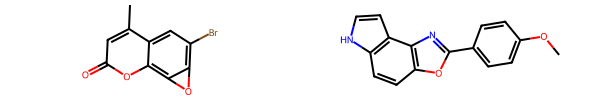

In [76]:
svg